# Main anaysis

### Setup

#### Imports

In [164]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

#### Overrides

In [165]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_pi=0.5",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_alpha=0.5",
    "simulation.dynamics.max_its=1e4", # important to specify maxits
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Helper function to filter data by config data

In [166]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_pi = df["meaning_dist_pi"] == curve_metadata.meaning_dist_pi

    imprecise_imitation_alpha = df["imprecise_imitation_alpha"].isin([curve_metadata.meaning_dist_pi, np.nan]) # allows curve, and constraints to be the same as curve.

    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan]) # allows curve

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_pi & imprecise_imitation_alpha & max_its]

    return df_subsetted

#### Load data

In [167]:
all_data_fp = "../../analysis_data/all_data.csv"
df_all = pd.read_csv(all_data_fp)
df_all

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,population_init_tau,seed,max_its,beta,eu_gamma=5.0,eu_gamma=0.005,eu_gamma=0.05,eu_gamma=0.5,eu_gamma=50.0,eu_gamma=500.0
0,0.0,10000.0,False,2.736911,2.693187,21.644243,29.078611,0.880260,0.004497,0.000032,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,False,0.272999,0.068292,3.234820,1669.606551,0.230465,0.346019,0.204422,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,False,0.050973,0.041775,3.226330,1566.855967,0.237828,0.079866,0.009166,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,False,0.059870,0.056137,3.238115,1479.062688,0.246565,0.084188,0.003693,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,False,0.123883,0.121412,3.285016,1372.198751,0.265050,0.107031,0.002365,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21841,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21842,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21843,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21844,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filter

In [168]:
df = get_df_subsetted_by_meaning_dists(df_all, config)
df

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,population_init_tau,seed,max_its,beta,eu_gamma=5.0,eu_gamma=0.005,eu_gamma=0.05,eu_gamma=0.5,eu_gamma=50.0,eu_gamma=500.0
0,0.0,10000.0,False,2.736911,2.693187,21.644243,29.078611,0.880260,0.004497,0.000032,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,False,0.272999,0.068292,3.234820,1669.606551,0.230465,0.346019,0.204422,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,False,0.050973,0.041775,3.226330,1566.855967,0.237828,0.079866,0.009166,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,False,0.059870,0.056137,3.238115,1479.062688,0.246565,0.084188,0.003693,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,False,0.123883,0.121412,3.285016,1372.198751,0.265050,0.107031,0.002365,...,NaN,6.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21841,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21842,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21843,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21844,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
df[df["meaning_dist_pi"] == 0.5].discriminative_need_gamma.value_counts()

discriminative_need_gamma
0.005      3208
50.000     3208
500.000    3208
5.000      3208
0.050      3208
0.500      3208
Name: count, dtype: int64

Make sure seed is a discrete variable

In [170]:
df["seed"] = df["seed"].astype(str)

Separate out observations into curves and simulation points

In [171]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Restrict dynamics

In [172]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [173]:
df_final_points.discriminative_need_gamma.unique()

array([5.e-03, 5.e+01, 5.e+02, 5.e+00, 5.e-02, 5.e-01])

In [174]:
# How does seed range?
df_final_points.seed.unique()

array(['6.0', '1.0', '0.0', '7.0', '2.0', '5.0', '4.0', '3.0'],
      dtype=object)

In [175]:
# Remember, popuation_init_gamma is nan if we go with the simple uniform sampling init
df_final_points.population_init_tau.unique()

array([nan])

### Visualize

In [176]:
# Make sure complexity max is np.log2(100)
assert np.allclose(df_ib_bound.complexity.max(), np.log2(100))

#### First visualize all data, across initializations and seeds

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


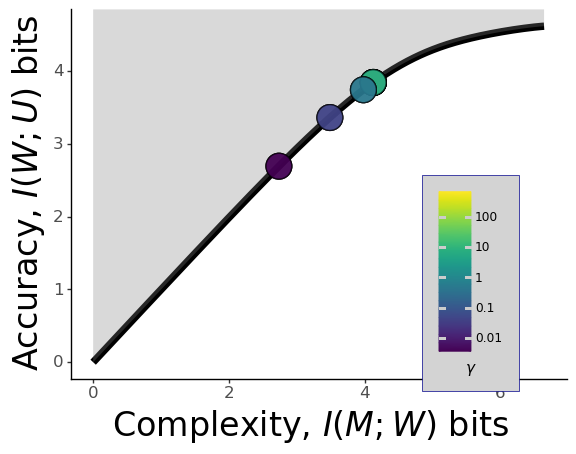

In [177]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # shape="seed",
            ),
        alpha=0.3,
        size=10,
    )
    + pn.labs(fill="$\\gamma$")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)

In [178]:
# Double check no min_epsilons are negative
df_final_points[df_final_points.min_epsilon < 0]

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,population_init_tau,seed,max_its,beta,eu_gamma=5.0,eu_gamma=0.005,eu_gamma=0.05,eu_gamma=0.5,eu_gamma=50.0,eu_gamma=500.0


#### Distribution of efficiency loss across converged emergent systems

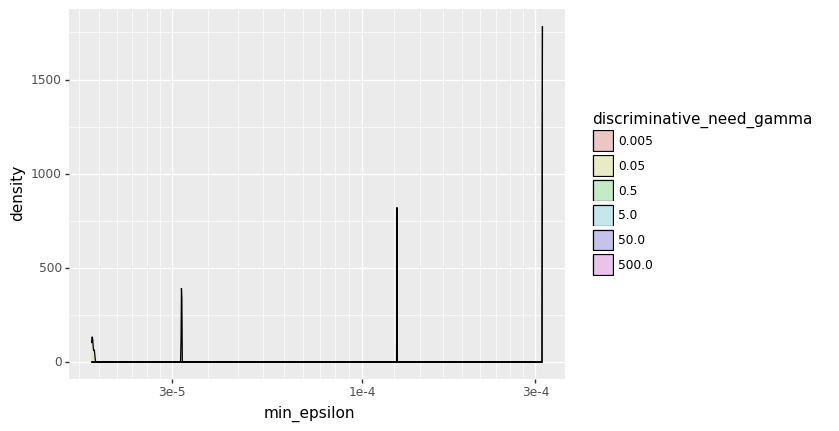

<ggplot: (383525825)>

In [179]:
df_final_points_gamma_discrete = df_final_points.copy()
df_final_points_gamma_discrete["discriminative_need_gamma"] = df_final_points_gamma_discrete["discriminative_need_gamma"].astype(str)

(
    pn.ggplot(
        df_final_points_gamma_discrete,
        pn.aes(
            x="min_epsilon",
            # fill="seed",
            fill="discriminative_need_gamma",
        )
    )
    # + pn.scale_fill_manual(values = fill_values_dict)
    + pn.geom_density(alpha=0.3)
    # + pn.geom_histogram(binwidth=0.01)
    + pn.scale_x_log10()
    # + pn.facet_wrap("discriminative_need_gamma")
)

# Okay, so for the first random seed I picked, the distribution of efficiency loss is highly peaked. This makes some sense, because if we look at the the trajectories, all colors appear to converge to the same respective points on y-axis.

#### Trajectories of efficiency loss

Filter

In [180]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["iteration"]
df_traj_analysis = df_traj_points.copy()


traj_analysis_columns = [
    "iteration", 
    "min_epsilon", 
    "min_epsilon_beta", 
    gamma, 
    "population_init_tau", 
    "complexity", 
    "accuracy", 
    "seed", 
    "kl_eb", 
    "eu_gamma", 
    "min_gnid", 
    "gnid_beta",
]
df_traj_analysis = df_traj_analysis[traj_analysis_columns]
df_traj_analysis

,iteration,min_epsilon,min_epsilon_beta,discriminative_need_gamma,population_init_tau,complexity,accuracy,seed,kl_eb,eu_gamma,min_gnid,gnid_beta
1,1.0,0.204422,1.001313,0.005,NaN,0.272999,0.068292,6.0,0.346019,0.230465,0.951718,1.000758
2,2.0,0.009166,1.000808,0.005,NaN,0.050973,0.041775,6.0,0.079866,0.237828,0.755006,1.000707
3,3.0,0.003693,1.000960,0.005,NaN,0.059870,0.056137,6.0,0.084188,0.246565,0.486646,1.000758
4,4.0,0.002365,1.001111,0.005,NaN,0.123883,0.121412,6.0,0.107031,0.265050,0.250243,1.000859
5,5.0,0.002160,1.001364,0.005,NaN,0.312657,0.310160,6.0,0.124525,0.312467,0.191014,1.001061
...,...,...,...,...,...,...,...,...,...,...,...,...
19883,8697.0,0.000125,1.416583,0.500,NaN,3.981928,3.743178,3.0,0.038581,0.363150,0.000748,1.409548
19884,9111.0,0.000125,1.416583,0.500,NaN,3.981928,3.743178,3.0,0.038581,0.363150,0.000748,1.409548
19885,9545.0,0.000125,1.416583,0.500,NaN,3.981928,3.743178,3.0,0.038581,0.363150,0.000748,1.409548
19886,9999.0,0.000125,1.416583,0.500,NaN,3.981928,3.743178,3.0,0.038581,0.363150,0.000748,1.409548


In [181]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

10000.0

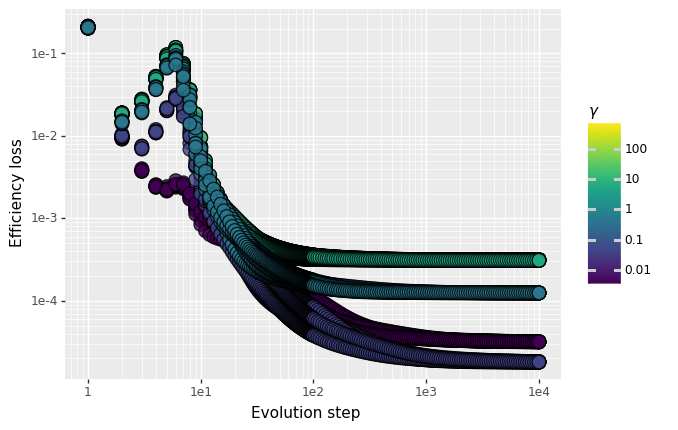

In [196]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
            fill="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        # size=0.5,
        size=1,
        alpha=0.8,
        )
    # + pn.geom_line()
    + pn.labs(fill="$\\gamma$")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    + pn.scale_fill_continuous(trans = 'log10')
    + pn.scale_x_log10()
)
print(plot)

Helper function to get mean and confidence intervals for a variable, grouped by gamma and iteration

In [183]:
from scipy import stats

# Calculate the mean and confidence intervals for each iteration
def mean_confidence_interval(data: pd.DataFrame, confidence=0.95) -> tuple[float]:
    n = len(data)
    mean, se = np.mean(data), stats.sem(data)
    interval = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return (mean, mean - interval, mean + interval)

def mean_conf_df(trajectory_data: pd.DataFrame, colname: str):
    df_summary = df_traj_analysis.groupby(['iteration', 'discriminative_need_gamma'])[colname].apply(mean_confidence_interval).apply(pd.Series)
    df_summary.columns = [f'mean_{colname}', 'lower_ci', 'upper_ci']
    df_summary = df_summary.reset_index()
    return df_summary


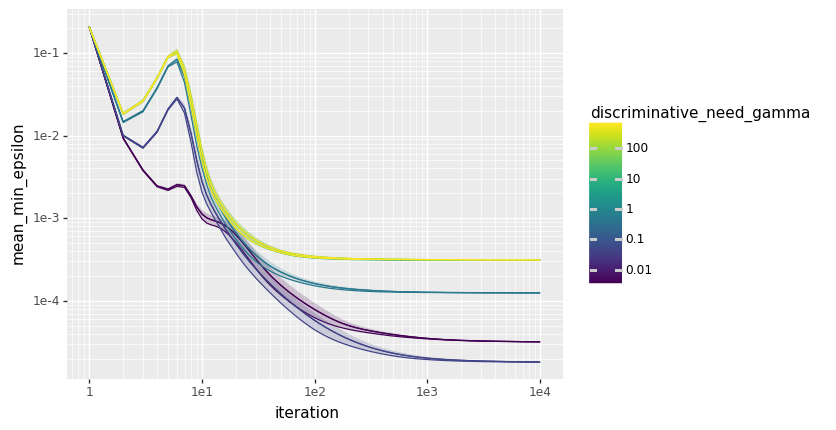

<ggplot: (391682901)>

In [184]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 701 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1568 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1568 rows containing missing values.


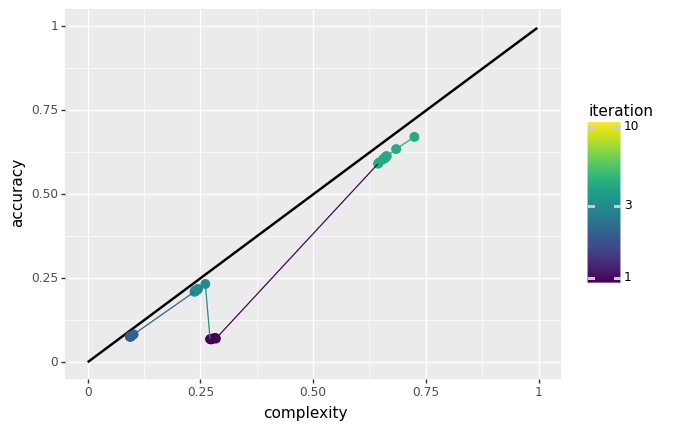

<ggplot: (397938601)>

In [185]:
# I'm so curious to see if we can see this on the trajectories. Zoom in on gamma=1000

df_traj_gamma_3 = df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == 500.0]

(
    pn.ggplot(
        df_traj_gamma_3,
        pn.aes(
            x="complexity",
            y="accuracy",
            color="iteration",
        ),
    )
    + pn.scale_color_continuous(trans = "log10", limits=[1,10])
    + pn.geom_line(df_ib_bound, size=1, color="black")
    + pn.geom_point(size=3)
    + pn.geom_line()
    + pn.ylim(0,1)
    + pn.xlim(0,1)
)

#### Visualize comp vs. EU

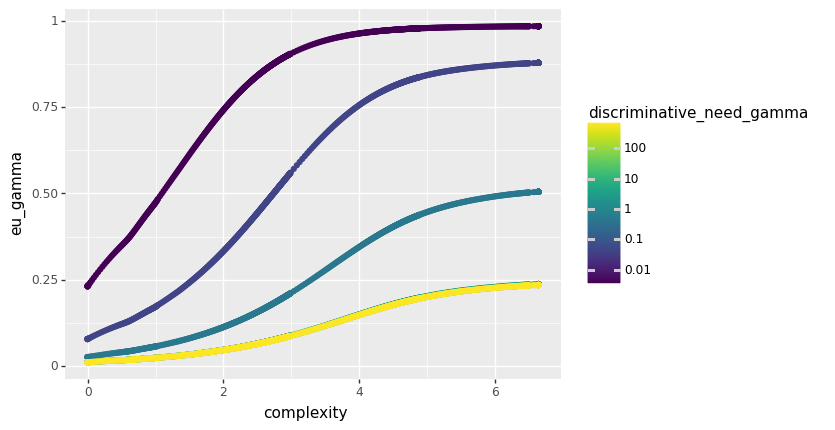

<ggplot: (391801739)>

In [186]:
# I'd like to know what the IB curves achieve in terms of their EU.

eu_cols = [colname for colname in df_ib_bound.columns if "eu_gamma=" in colname]
cols = ["complexity", "accuracy",] + eu_cols


df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)

# Yet another bandaid for string parsing the 0.5 width.

df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

# df_ib_eu

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")
    + pn.geom_point()
)

together?

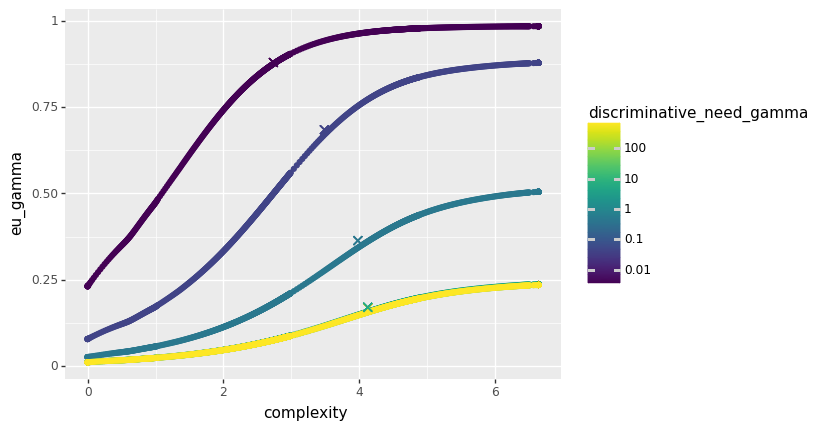

<ggplot: (391735351)>

In [187]:
(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.geom_point(shape="o")

    # Now the simulation data
    + pn.geom_point(
        data=df_final_points,
        shape="x",
        size=3,
    )
    + pn.scale_color_continuous(trans = "log10")

    # + pn.ylim(0, 0.25)
)

In [188]:
# Sanity check that a bijective sender and bayesian receiver team will achieve at most 0.25 expected utility in the highest gamma game, because of the meaning confusion probabilities

game = Game.from_hydra(config)

encoder = np.eye(len(game.universe))
# decoder = encoder.T # not nec. ib
decoder = (encoder * game.prior[:, None]) / (encoder.T @ game.prior) @ game.meaning_dists

optimal_team = optimal_team = game.meaning_dists @ encoder @ decoder @ game.meaning_dists
high_gamma_utility = np.eye(len(game.universe))

# expected utility
np.sum(game.prior * (optimal_team * high_gamma_utility))

0.23426270974019586

In [189]:
# check that without confusion we achieve 1.0 utility
np.sum(game.prior * (np.eye(len(game.universe)) * game.utility))

0.9999999999999998

is it possible to view trajectories too? yes.

How to read the below plot: lines are ib optima, circles are trajectories of emergent systems.

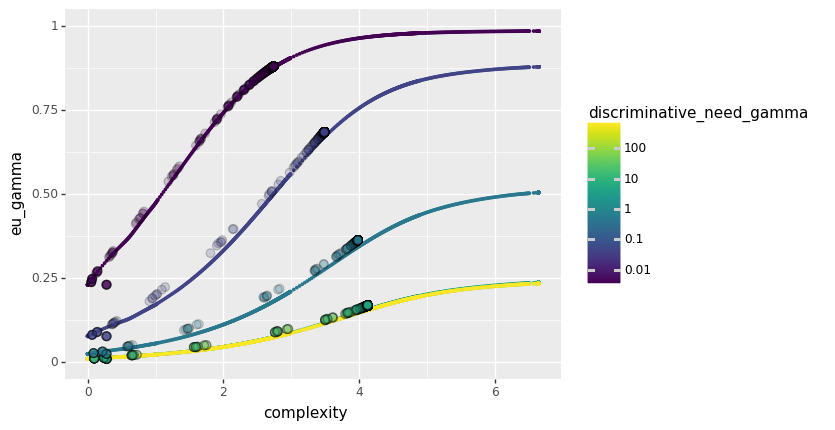

<ggplot: (398278855)>

In [190]:
df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)
df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")

    + pn.geom_point(
        # shape="o", 
        size=0.5,
    )

    # Now the simulation data
    + pn.geom_point(
        data=df_traj_analysis, # why does the highest gamma always get overplotted? maybe we should drop anyway...
        mapping=pn.aes(
            # size="iteration",
            fill="discriminative_need_gamma",
        ),
        shape="o",
        size=3,
        alpha=0.2,
        color="black",
    )
    + pn.scale_fill_continuous(trans = "log10")
    + pn.ylim(0,1)
)

#### Visualize kl_eb over time

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract


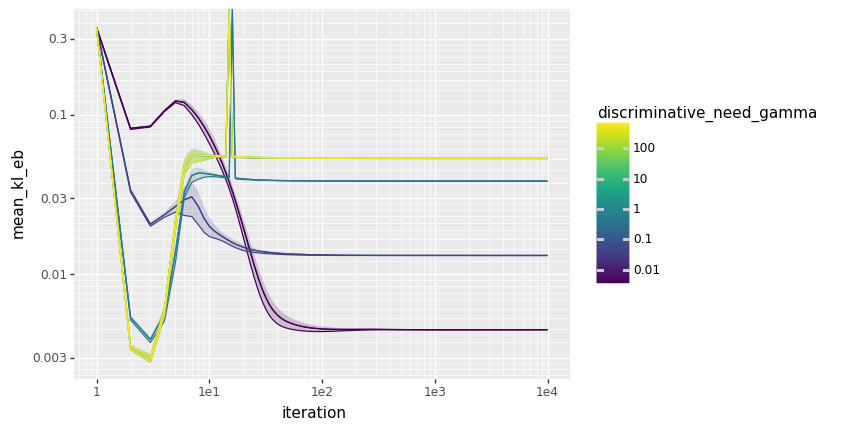

<ggplot: (391616323)>

In [191]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "kl_eb"),
      pn.aes(
         x="iteration",
         y="mean_kl_eb",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

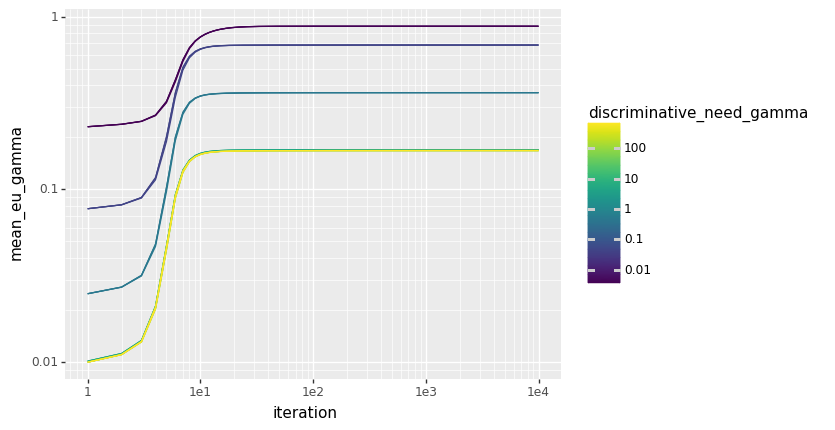

<ggplot: (391422802)>

In [192]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "eu_gamma"),
      pn.aes(
         x="iteration",
         y="mean_eu_gamma",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

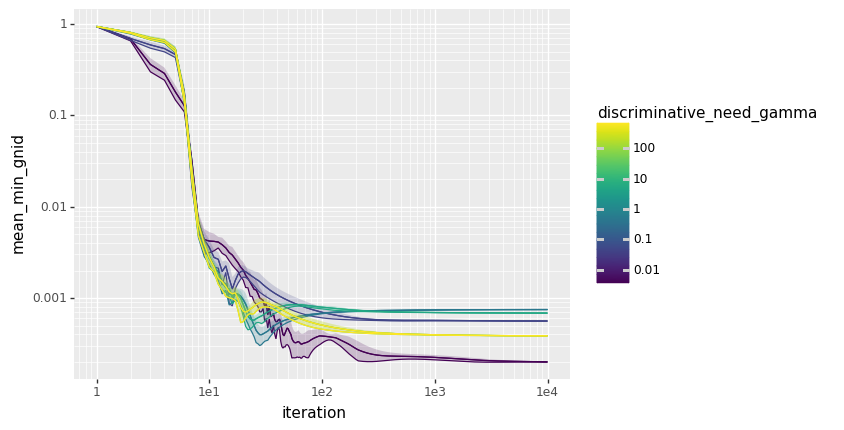

<ggplot: (398070697)>

In [193]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_gnid"),
      pn.aes(
         x="iteration",
         y="mean_min_gnid",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

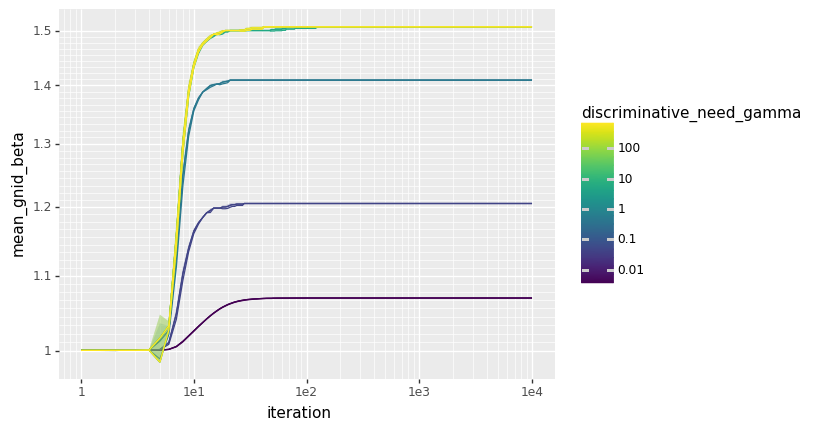

<ggplot: (397120086)>

In [194]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "gnid_beta"),
      pn.aes(
         x="iteration",
         y="mean_gnid_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

N.B., this is different from beta fitted by min epsilon!

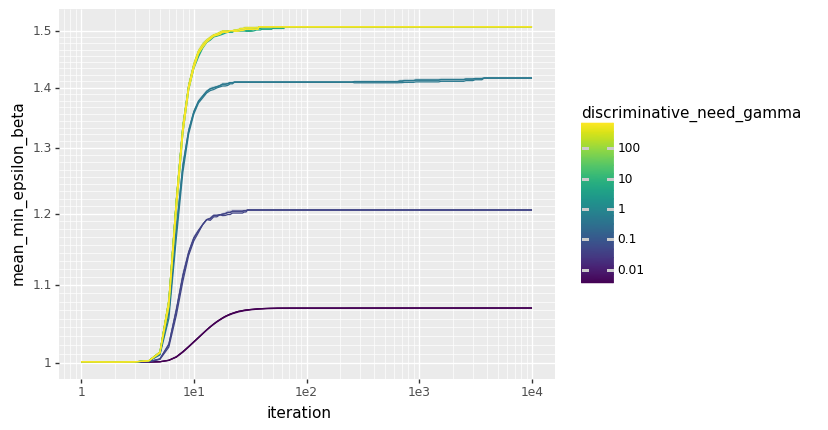

<ggplot: (397762777)>

In [195]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon_beta"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

would be interesting to compare these betas, but i'll wait until someone asks